### Set up the environment

In [94]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

from sklearn.decomposition import PCA, FastICA, FactorAnalysis, NMF
from sklearn.preprocessing import StandardScaler


plt.style.use('ggplot')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.random.seed(123)

### Generate some artificial data

Here we are creating our own viewing data. This is a great way to understand the dimension reduction process because when we generate the data we are starting with the *taste* dimensions that we will be trying to recover. In effect, we know the answer, which isn't going to be true in real life applications, but which is useful when we want to understand how things work and how well a dimension reduction process is working. First we create the viewers.,

In [95]:
num_viewers = 10000
num_films = 10

action = np.random.beta(1,1,num_viewers) # uniform
sci_fi = np.random.beta(0.1, 0.1,num_viewers)  # marmite
period_drama = np.random.beta(2, 2,num_viewers) # no strong opinion

And next the film titles

In [96]:
sci_fi_name_1= ["evil", "metalic", "cosmic", "blood thirsty"]
sci_fi_name_2= [" droid", " zombie", " space zebra"]
sci_fi_name_3= [" from outer space", " invasion", " attack on Mars"]
action_name_1= ["ultimate", "bad", "fatal", "unstoppable"]
action_name_2= [" weapon", " cop", " tough guy"]
action_name_3= [" in the line of fire", " death wish", " mission"]
period_drama_name_1= ["pride", "obstinacy", "indolence", "luxury"]
period_drama_name_2= [" and", " in", " over"]
period_drama_name_3= [" prejudice", " paradise", " ecstacy"]
sequel = ["", " V", " II", " III", " IV"]

sci_fi_films = [np.random.choice(sci_fi_name_1) + np.random.choice(sci_fi_name_2) 
                + np.random.choice(sci_fi_name_3) + np.random.choice(sequel) for x in range(num_films)]
period_drama_films = [np.random.choice(period_drama_name_1) + np.random.choice(period_drama_name_2) 
                      + np.random.choice(period_drama_name_3) + np.random.choice(sequel) for x in range(num_films)]
action_films = [np.random.choice(action_name_1) + np.random.choice(action_name_2) + np.random.choice(action_name_3) 
                + np.random.choice(sequel) for x in range(num_films)]

print(sci_fi_films + period_drama_films + action_films)

['cosmic zombie attack on Mars', 'blood thirsty zombie invasion IV', 'cosmic zombie from outer space IV', 'evil space zebra from outer space III', 'evil space zebra attack on Mars IV', 'blood thirsty droid attack on Mars', 'blood thirsty zombie invasion V', 'evil zombie invasion III', 'evil zombie from outer space', 'cosmic zombie invasion V', 'indolence and ecstacy III', 'luxury over paradise III', 'indolence over ecstacy', 'luxury in prejudice II', 'indolence and prejudice III', 'obstinacy in ecstacy II', 'indolence over ecstacy', 'pride and paradise II', 'luxury and prejudice IV', 'luxury in paradise', 'ultimate cop mission II', 'ultimate weapon death wish', 'unstoppable tough guy mission V', 'bad cop death wish III', 'unstoppable weapon mission III', 'fatal weapon mission', 'fatal weapon mission II', 'bad weapon in the line of fire II', 'bad weapon in the line of fire', 'unstoppable weapon in the line of fire']


We randomly assign a *quality* to each film.

In [97]:
sci_fi_rep = np.random.uniform(0, 1, num_films)
period_drama_rep = np.random.uniform(0, 1, num_films)
action_rep = np.random.uniform(0, 1, num_films)

Then we use the binomial distribution to decide whether the viewer watched the film (depending of their taste and the quality of the film)

In [98]:
action_viewing = np.transpose(np.array([[np.asscalar(np.random.binomial(1,x*y,1)) for x in action] for y in action_rep]))
period_drama_viewing = np.transpose(np.array([[np.asscalar(np.random.binomial(1,x*y,1)) for x in period_drama] for y in period_drama_rep]))
sci_fi_viewing = np.transpose(np.array([[np.asscalar(np.random.binomial(1,x*y,1)) for x in sci_fi] for y in sci_fi_rep]))
viewing = np.concatenate((action_viewing, period_drama_viewing, sci_fi_viewing), axis = 1)

And the poisson distribution to determine the minutes watched if they did see the film.

In [99]:
action_viewing_mins = np.array([np.random.poisson(x*50,num_films).tolist() for x in action])
period_drama_viewing_mins = np.array([np.random.poisson(x*50,num_films).tolist() for x in period_drama])
sci_fi_viewing_mins = np.array([np.random.poisson(x*50,num_films).tolist() for x in sci_fi])
viewing_mins = np.concatenate((action_viewing_mins, period_drama_viewing_mins, sci_fi_viewing_mins), axis = 1)
viewing = np.multiply(viewing, viewing_mins)

We put the results together in a dataframe for inspection.

In [100]:
viewing_df = pd.DataFrame(viewing)
viewing_df.columns = sci_fi_films + action_films + period_drama_films
viewing_df.head()

,cosmic zombie attack on Mars,blood thirsty zombie invasion IV,cosmic zombie from outer space IV,evil space zebra from outer space III,evil space zebra attack on Mars IV,blood thirsty droid attack on Mars,blood thirsty zombie invasion V,evil zombie invasion III,evil zombie from outer space,cosmic zombie invasion V,...,indolence and ecstacy III,luxury over paradise III,indolence over ecstacy,luxury in prejudice II,indolence and prejudice III,obstinacy in ecstacy II,indolence over ecstacy,pride and paradise II,luxury and prejudice IV,luxury in paradise
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,24,0,23,0,36,0,0,0
3,0,0,0,53,51,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,26,22,0,0,0,0,0,...,30,47,0,0,0,37,0,0,36,0


### Principal Component Analysis

I'll take you through the theory on the whiteboard. This is how it is done in scikit-learn. First we scale the data (important since PCA works by maximising variance).

In [101]:
scaler = StandardScaler()
viewing_scaled = scaler.fit_transform(viewing)

Next we set up and apply the principal component transfromation.

In [102]:
pca = PCA()
viewing_reduced = pca.fit_transform(viewing_scaled)

Then we plot the explained variance against the number of components.

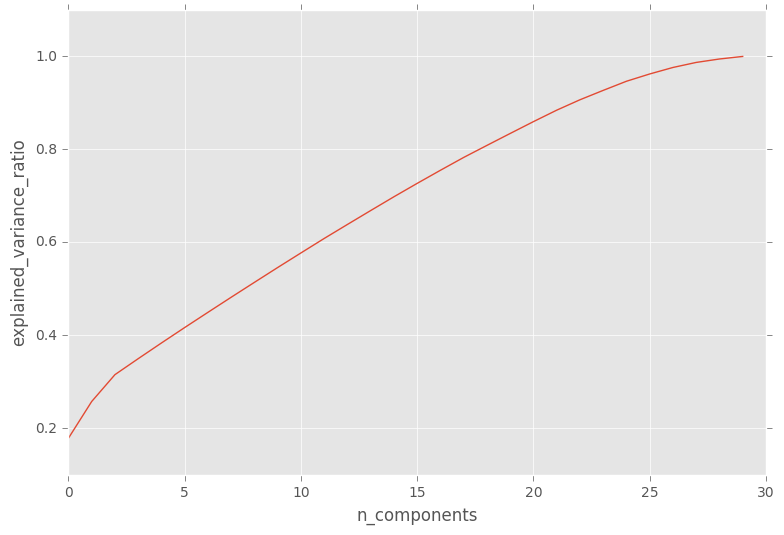

In [103]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(pca.explained_variance_ratio_.cumsum())
ax.set_xlabel('n_components')
ax.set_ylabel('explained_variance_ratio');

A lot of the variance is caused by the quality of the film (and by noise) so the first 3 components only explain about 30% of the variance. Next we inspect and interpret the loadings.

In [104]:
loadings_array = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings = pd.DataFrame(loadings_array.T)
loadings.columns = action_films + period_drama_films + sci_fi_films
loadings.index = loadings.index+1
loadings.head().transpose()

,1,2,3,4,5
ultimate cop mission II,-0.00,0.00,0.58,0.04,-0.07
ultimate weapon death wish,0.00,0.02,0.38,-0.16,0.05
unstoppable tough guy mission V,0.01,-0.01,0.34,0.12,0.29
bad cop death wish III,-0.01,0.02,0.59,0.02,-0.01
unstoppable weapon mission III,-0.01,0.01,0.44,0.05,-0.07
fatal weapon mission,0.00,-0.03,0.23,0.23,-0.07
fatal weapon mission II,-0.01,-0.01,0.39,-0.07,-0.11
bad weapon in the line of fire II,0.00,-0.00,0.22,-0.62,-0.23
bad weapon in the line of fire,-0.02,0.02,0.57,0.02,0.05
unstoppable weapon in the line of fire,-0.00,0.02,0.12,0.60,0.10


It is useful to do this with a heatmap

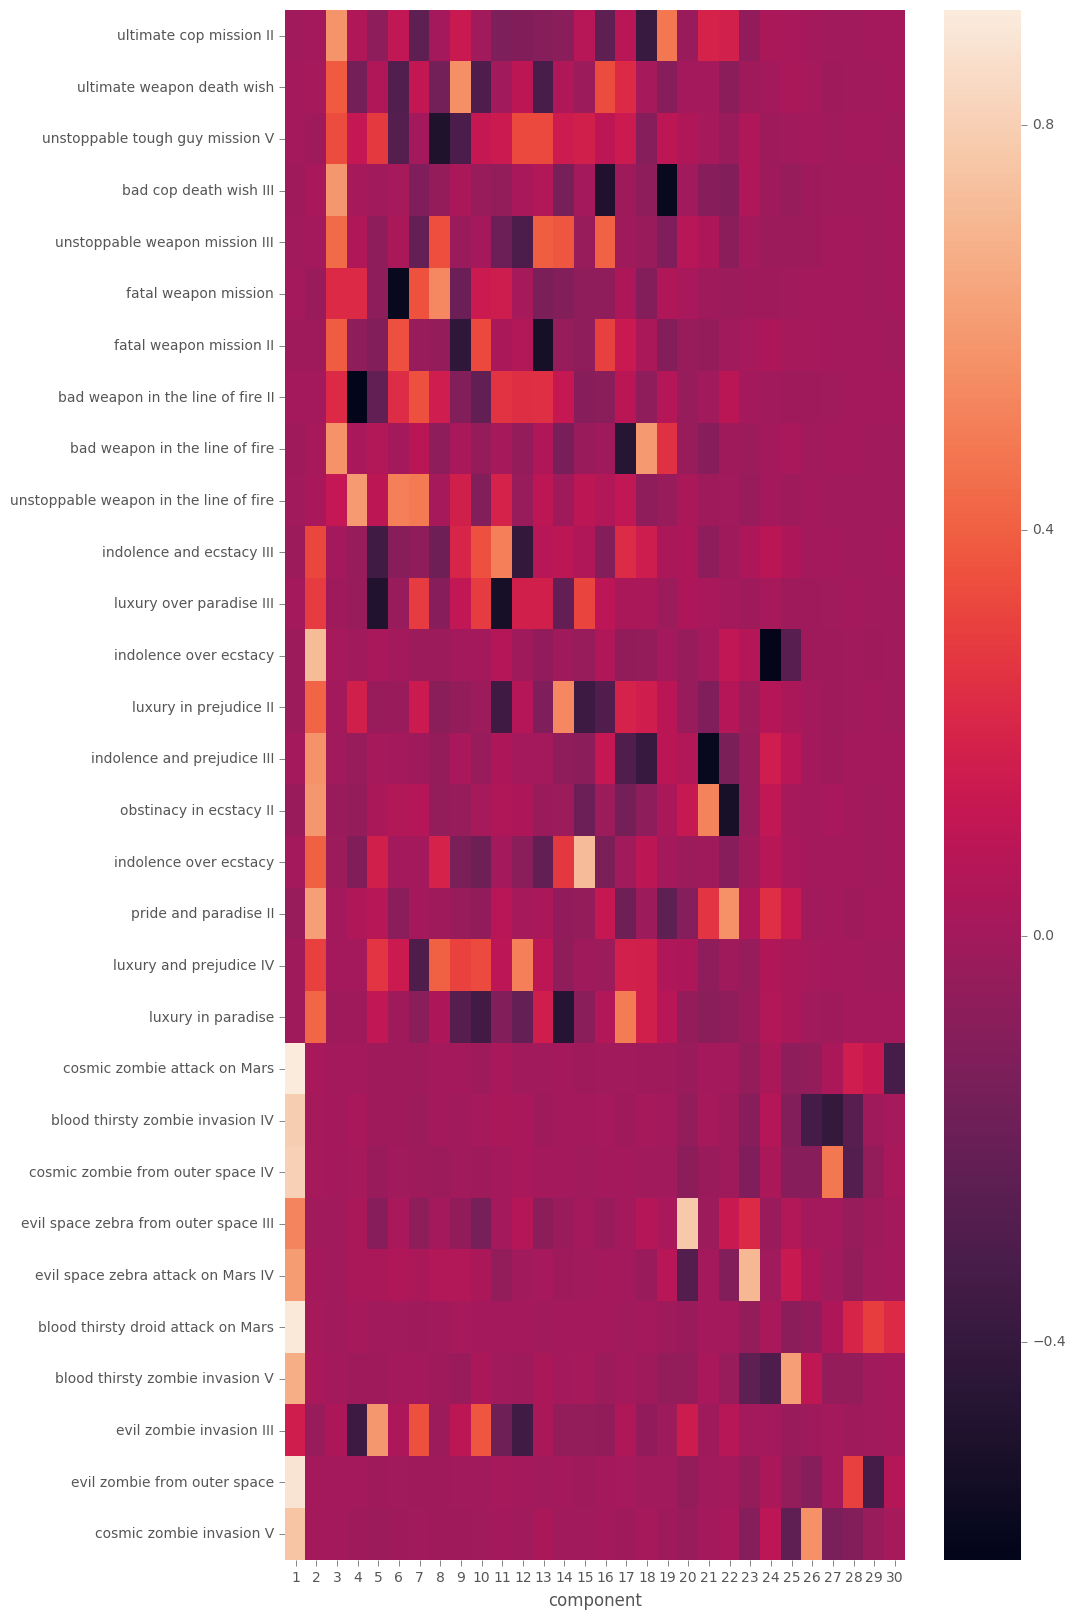

In [105]:
fig, ax = plt.subplots(figsize=(10,20))
#sns.heatmap(loadings.T, mask=(loadings.T < 0.5) & (loadings.T > -0.5), annot=True)
sns.heatmap(loadings.T, )
ax.set_xlabel('component');

The great thing about having generated our own data, is that we know the answers and can assess how well PCA has done at recovering them.

In [125]:
viewing_reduced_df = pd.DataFrame(viewing_reduced)
col_names = ["pc_" + str(x+1) for x in range(30)]
viewing_reduced_df.columns = col_names
print("Correlation of first PC with sci-fi is %s ")
print (viewing_reduced_df.pc_1.corr(pd.Series(sci_fi)))
print("Correlation of second PC with period drama")
print (viewing_reduced_df.pc_2.corr(pd.Series(period_drama)))
print("Correlation of third PC with action")
print (viewing_reduced_df.pc_3.corr(pd.Series(action)))

Correlation of first PC with sci-fi is %s 
0.951063381275
Correlation of second PC with period drama
0.802617173305
Correlation of third PC with action
0.682325565314


Not too bad. Let's now compare some of the other dimension reduction techniques on offer in scikit-learn.

### Factor Analysis

Models the correlation between observed variables by positing the existence of some latent (hidden) variables that explain the correlation. The classic example is IQ, in which correlation in observable test results is explained by intelligence, which of course is not directly measurable.

**When to use it**
When there is good reason to suppose latent causes exist (as opposed to just wanting to reduce the number of dimensions)

**Strengths**
Provides a proper statistical model that accounts for such things as noise.

**Weaknesses**
Need to specify the number of factors

In [143]:
fa = FactorAnalysis()
viewing_reduced_fa = fa.fit_transform(viewing_scaled)
fa_df = pd.DataFrame(viewing_reduced_fa)
print("Correlation of first factor with sci-fi is %s ")
print (fa_df[0].corr(pd.Series(sci_fi)))
print("Correlation of second factor with period drama")
print (fa_df[1].corr(pd.Series(period_drama)))
print("Correlation of third factor with action")
print (fa_df[2].corr(pd.Series(action)))


Correlation of first PC with sci-fi is %s 
0.959182967619
Correlation of second PC with period drama
0.809689086763
Correlation of third PC with action
0.686609374704


In [ ]:
Very similar results

### Non-negative matrix factorisation

In the context of text analysis this refers to a matrix factorisation that decomposes a document-term matrix into a document-feature * feature-document matrix. This allows us to reduce a large set of terms to a set of features or topics. We can then cluster the documents in a feature space.

**When to use it**
As an alternative to LDA for extracting topics from documents.

But since we are dealing with non negative counts it might work well for us.

In [147]:
nmf = NMF()
viewing_reduced_nmf = nmf.fit_transform(viewing) #Not scaled!
nmf_df = pd.DataFrame(viewing_reduced_nmf)

print("Correlation of first factor with sci-fi is %s ")
print (nmf_df[0].corr(pd.Series(sci_fi)))
print("Correlation of second factor with period drama")
print (nmf_df[1].corr(pd.Series(period_drama)))
print("Correlation of third factor with action")
print (nmf_df[2].corr(pd.Series(action)))


Correlation of first factor with sci-fi is %s 
0.761116871366
Correlation of second factor with period drama
0.658325090056
Correlation of third factor with action
0.428334308489


It's ok but not as successful as the previous two methods

### Independent component analysis

Each variable in a multivariate dataset is taken to be a linear combination of some latent variables. ICA then tries to recover the original variables.

Imagine four microphones in a room picking up a conversation between four people. ICA will recover each separate voice. 

**When to use it**
When you want to separate out signals than have been mixed together (compare to PCA which is more used for reducing the number of dimensions.

Therefore we wouldn't expect it to work well here. Let's try it anyway. (Forgive the code!)

In [142]:
ica = FastICA()
viewing_reduced_ica = ica.fit_transform(viewing_scaled)
ica_df = pd.DataFrame(viewing_reduced_ica)

cor_df = np.array(pd.DataFrame({"sci-fi": sci_fi, "period_drama": period_drama, "action": action, "ic_1": ica_df[0], 
              "ic_2": ica_df[1] , "ic_3": ica_df[2] }).T)
pd.DataFrame(np.corrcoef(cor_df))

,0,1,2,3,4,5
0,1.00,-0.00,0.01,-0.00,0.00,-0.01
1,-0.00,1.00,0.00,-0.00,-0.36,0.00
2,0.01,0.00,1.00,-0.00,0.00,-0.95
3,-0.00,-0.00,-0.00,1.00,0.23,-0.00
4,0.00,-0.36,0.00,0.23,1.00,-0.01
5,-0.01,0.00,-0.95,-0.00,-0.01,1.00


As expected a complete fail!